In [1]:
using GynC

In [2]:
include("../src/weightedsamples.jl")

weightduplicates (generic function with 1 method)

In [3]:
all=JLD.load("../data/0911/allsamples.jld")["samples"];
size(all)

(45,)

In [4]:
s=vcat([a[50_001:3000:end,:] for a in all]...);
size(s)

(2250,116)

In [5]:
s, w = weightduplicates(s)

(
[19040.3 35681.5 … 6.55635e-5 28.6965; 18787.2 28005.9 … 6.18674e-5 28.5743; … ; 20583.9 11133.5 … 7.9398e-5 30.7602; 7223.93 22604.1 … 5.99331e-5 31.0581],

[1,1,1,1,1,1,1,1,1,1  …  1,1,1,1,1,1,1,1,1,1])

In [6]:
zs = GynC.phi(s);
nonnans = find(z->!any(isnan(z)),zs)
s = s[nonnans,:]
w = w[nonnans]
w = w/sum(w);
w0 = w
size(s)

(2238,116)

In [70]:
alldatas = [Lausanne(i).data for i=1:45]
gooddata  = filter(x->any(!isnan(x)), alldatas)
srand(1)
@profile hz=GynC.hzobj(s, gooddata)

(::#78) (generic function with 1 method)

In [74]:
Profile.clear()
ssmall = s[1:5:end,:]
@profile GynC.hzobj(ssmall, gooddata)
Profile.print()

1    ./event.jl:379; (::Base.##349#350{IJulia.#send_st...
 1 ./event.jl:319; wait(::Timer)
1    ./event.jl:384; (::Base.##349#350{IJulia.#send_st...
 1 ...0.5/IJulia/src/stdio.jl:72; send_stdio(::String)
  1 ....5/IJulia/src/stdio.jl:79; send_stream(::String)
   1 ./dict.jl:687; getindex
    1 ./dict.jl:543; ht_keyindex(::Dict{String,Base.A...
2948 ./task.jl:360; (::Base.##755#757{Base.AsyncColle...
 2948 ./asyncmap.jl:63; macro expansion
  2947 ....5/GynC/src/optim2.jl:32; phi(::Array{Float64,1})
   1    ./abstractarray.jl:752; getindex
    1 ./multidimensional.jl:270; _getindex
     1 ./abstractarray.jl:284; checkbounds
      1 ./abstractarray.jl:270; checkbounds
       1 ./abstractarray.jl:309; checkbounds_indices
        1 ./abstractarray.jl:319; checkbounds_indices
         1 ./abstractarray.jl:377; checkindex
   1    ./multidimensional.jl:291; _unsafe_getindex(::Base.LinearF...
    1 ./multidimensional.jl:296; macro expansion
   2945 ....5/GynC/src/model.jl:88; forwardsol(::Array

In [8]:
GynC.logLw(w,hz.Ld)

LoadError: LoadError: UndefVarError: h not defined
while loading In[8], in expression starting on line 1

In [9]:
GynC.Hz(w,hz.Lz)

LoadError: LoadError: UndefVarError: h not defined
while loading In[9], in expression starting on line 1

In [10]:
@time hz(w)

  0.365540 seconds (194.90 k allocations: 7.280 MB, 6.33% gc time)


6.667166661713814

In [17]:
using ForwardDiff

function gradify(f, x)
  out=GradientResult(x)
  function df(x)
    ForwardDiff.gradient!(out, f, x)
    ForwardDiff.value(out), ForwardDiff.gradient(out)
  end
end

Dhz = gradify(hz, w0);

In [18]:
@time h, grad = Dhz(w)

 32.159642 seconds (4.53 M allocations: 418.968 MB, 0.85% gc time)


(6.667166661713807,[50.8598,48.0908,69.6125,65.7687,13.4936,80.9746,24.7552,25.9802,48.2414,66.7631  …  69.9181,46.3816,59.8503,43.2466,45.9096,51.3647,74.0958,60.9753,52.2571,15.4686])

In [19]:
@time GynC.psi_S(w, grad)

  0.127912 seconds (53.57 k allocations: 2.226 MB)


2238-element Array{Float64,1}:
  0.0015257  
  0.000291196
  0.00988625 
  0.00817256 
 -0.0151333  
  0.0149518  
 -0.0101125  
 -0.00956641 
  0.000358317
  0.0086159  
  0.0028039  
  0.00433074 
  0.00373588 
  ⋮          
 -0.000465649
 -0.000143212
  0.0100225  
 -0.00047082 
  0.00553392 
 -0.00186849 
 -0.000681265
  0.0017508  
  0.0118851  
  0.0060355  
  0.00214866 
 -0.0142528  

In [25]:
function pseudoeuler(w; h=1, project=projectscale)
    _,df = Dhz(w)
    project(w+h*df)
end

projectscale(w) = w/sum(w)

projectscale (generic function with 1 method)

In [26]:
@time pseudoeuler(w0, h=0.01)

 30.165283 seconds (3.02 M allocations: 361.684 MB, 0.67% gc time)


2238-element Array{Float64,1}:
 0.00046913 
 0.000443611
 0.000641953
 0.000606529
 0.000124766
 0.000746665
 0.000228553
 0.000239842
 0.000444999
 0.000615693
 0.000495552
 0.000527114
 0.000514817
 ⋮          
 0.000427966
 0.000434631
 0.000644769
 0.000427859
 0.000551985
 0.000398968
 0.000423509
 0.000473783
 0.000683271
 0.000562353
 0.000482007
 0.000142968


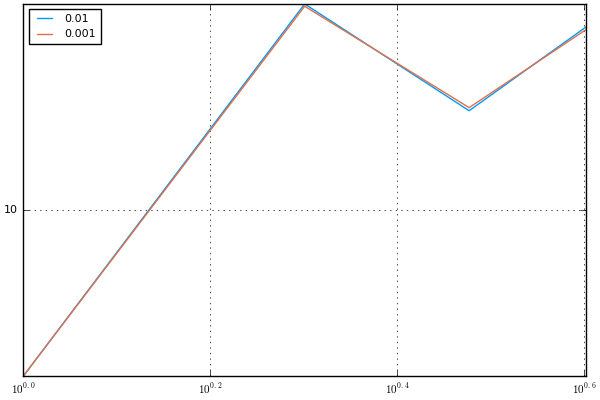

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [27]:
using Plots
niter=3
p=plot(xaxis=:log)
for h=[1, 0.1, 0.01, 0.001, 0.0001]
  wn=w0
  hzs=[hz(wn)]
  for i=1:niter
      wn = pseudoeuler(wn, h=h)
      any(wn .< 0) && warn("negative weights")
      push!(hzs, hz(wn))
  end
  plot!(p,hzs, label=h)
end
p

In [28]:
using Iterators

In [49]:
n = 20
@time wns = [
collect(take(iterate(w->project(pseudoeuler(w, h=h)), w0), n))
for project in [projectscale, GynC.projectsimplex],
    h = [0.1, 0.01, 0.001, 0.0001, 0.00001]]

6045.886126 seconds (604.15 M allocations: 70.592 GB, 0.71% gc time)


2×5 Array{Array{Any,1},2}:
 Any[[0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831  …  0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831,0.000445831],[0.000469149,0.000443609,0.000642116,0.000606662,0.0001245,0.000746915,0.000228372,0.000239671,0.000444998,0.000615834  …  0.000644934,0.000427844,0.000552073,0.000398929,0.000423491,0.000473806,0.000683468,0.00056245,0.000482037,0.000142717],[0.000477578,0.000453279,0.000642527,0.000608653,0.00015522,0.000742794,0.000250535,0.000261061,0.000454605,0.000613923  …  0.000645221,0.000438273,0.000556482,0.000410824,0.000434205,0.000481825,0.000682075,0.000566444,0.000490036,0.000171648],[0.000473124,0.000448022,0.000643499,0.000608518,0.000138593,0.000747031,0.00023813,0.000249058,0.00044939,0.0006149  …  0.000646281,0.000432508,0.000554644,0.000404142,0.000428298,0.000477544,0.000684325,0.000564927,0.000486131,0.000


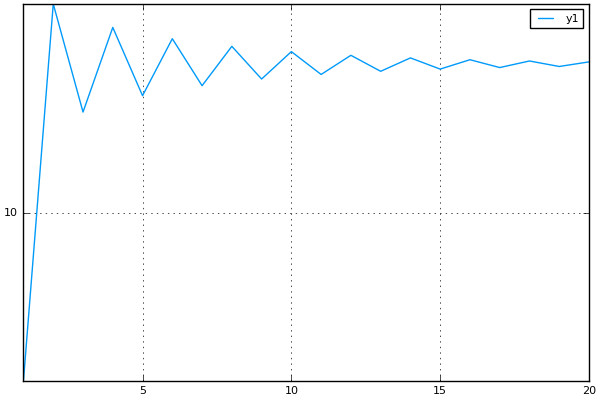

In [61]:
test = map(hz, wns[2,2])
plot(test)

In [67]:
any(wns[2,2][2] .< 0)

false

In [63]:
map(hz,wns[2,2])

20-element Array{Any,1}:
  6.66717
 14.1447 
 11.9976 
 13.6787 
 12.3229 
 13.4543 
 12.5213 
 13.3028 
 12.6538 
 13.1978 
 12.7444 
 13.1245 
 12.8072 
 13.0731 
 12.8509 
 13.0371 
 12.8814 
 13.0118 
 12.9027 
 12.9941 


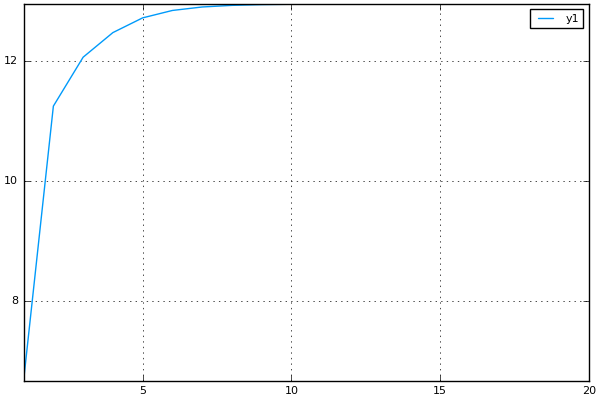

In [ ]:
weightedhist(v::Array{T<:Any,1}, w::Array{T<:Any,1}, nbins) at /home/numerik/bzfsikor/.julia/v0.5/GynC/src/plot.jl:104()


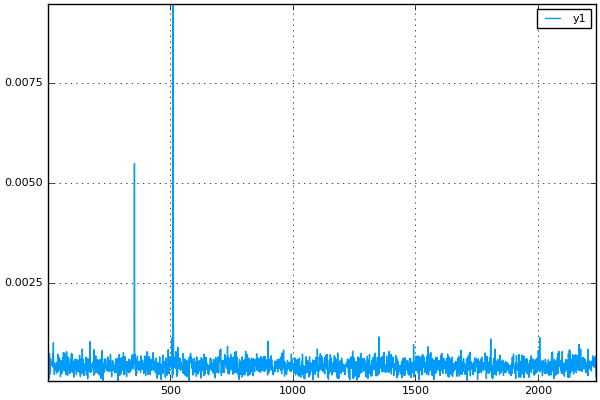

In [69]:
plot(wns[2,2][2])


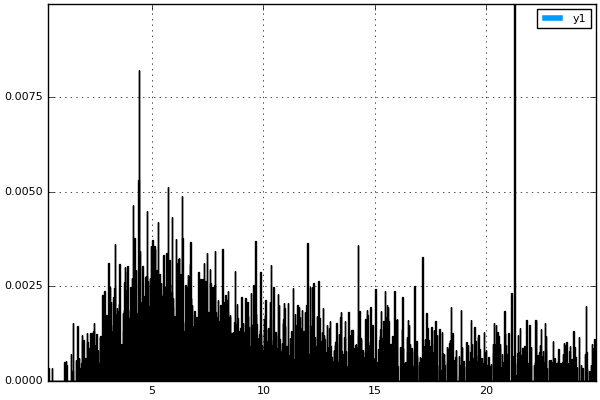

In [68]:
bar(GynC.weightedhist(s[:,8], wns[2,2][2], 1000)...)


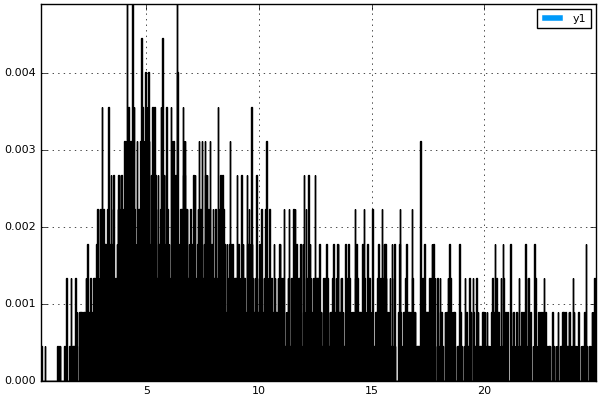

In [48]:

bar(GynC.weightedhist(s[:,8], w0, 1000)...)